In [15]:
% matplotlib inline
% reload_ext autoreload
% autoreload 2

import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import POW_FIELDS, TEMP_FIELDS

from thermo import CONSTANTS
# source file, see docs/5-dataset.md for info on field names
Chiller1File = '../SystemInfo/ESB Chiller 1.csv'

# Trends

## Dataset

The dataset describes input/output powers, temperatures, and cooling by various components of a chiller with a water-cooled condenser and a cooling tower. More details are in `/docs/`.

After pre-processing, all measurements are in SI units (Kelvins, watts) except for the field `KWPerTon` where units are explicit in the measurement.

In [16]:
# Read pre-processed data
c1df = pd.read_csv(Chiller1File, index_col='Time', parse_dates=True, dtype=float)
c1df.head()

,FlowEvap,KWPerTon,PerChilLoad,PerFreqFanA,PerFreqFanB,PerHumidity,PowChi,PowChiP,PowConP,PowFanA,PowFanB,PowIn,TempAmbient,TempCondIn,TempCondOut,TempEvapIn,TempEvapOut,TempWetbulb,Tons
Time,,,,,,,,,,,,,,,,,,,
2018-05-01 00:00:00,0.001819,0.561302,0.228145,1.0,1.0,0.307254,98300.0,17310.0,960.0,10150.000,9290.000,136010.000,292.669383,287.66,295.65,279.99,278.64,283.716111,615901.890812
2018-05-01 00:10:00,0.001818,0.468715,0.262595,1.0,1.0,0.310525,107000.0,17300.0,2040.0,9730.000,9089.999,145159.999,292.615115,290.11,297.02,280.53,278.77,283.725161,802840.305358
2018-05-01 00:15:00,0.001818,0.508448,0.237714,1.0,1.0,0.310525,98900.0,17110.0,1130.0,9849.999,9889.999,136879.998,292.590166,287.25,295.60,280.19,278.69,283.706150,684075.099168
2018-05-01 00:25:00,0.001820,0.528174,0.197377,1.0,1.0,0.313801,104200.0,17320.0,2280.0,10160.000,9950.000,143910.000,292.567083,291.76,296.24,280.37,278.85,283.738617,693817.528474
2018-05-01 00:30:00,0.001820,0.464545,0.243300,1.0,1.0,0.317169,97700.0,17280.0,3910.0,10110.000,9629.999,138629.999,292.457706,287.51,295.82,280.29,278.67,283.706072,739640.747043


## Efficiency metrics

### Coefficient of performance

$$
\begin{align*}
COP_{max cooling} &= \frac{T_{cold}}{T_{hot} - T_{cold}}  \\
COP &= \frac{\texttt{Energy Extracted}}{\texttt{Energy Input}}
\end{align*}
$$

In [17]:
# Measure maximum Coefficient of Performance (COP) for cooling
# for the ENTIRE chiller plant.
# Currently in the dataset, water flow rate for the condenser loop
# is not available - so COP for condenser/cooling tower cannot be
# calculated.
c1df['COPMax'] = c1df['TempEvapIn'] / (c1df['TempEvapIn'] - c1df['TempEvapOut'])

# Measured achieved COP
c1df['COP'] = c1df['Tons'] / c1df['PowIn']

In [18]:
# Aggregating measurements across days by time of day
downsampled = c1df.asfreq('15T')                     # downsampling readings for cleaner plot
bytime = downsampled.groupby(downsampled.index.time) # group all records by time of day
means = bytime.mean()                                # calculate average values across days
means.set_index(pd.to_datetime(means.index, format='%H:%M:%S').time, inplace=True)

## Plots

### COP

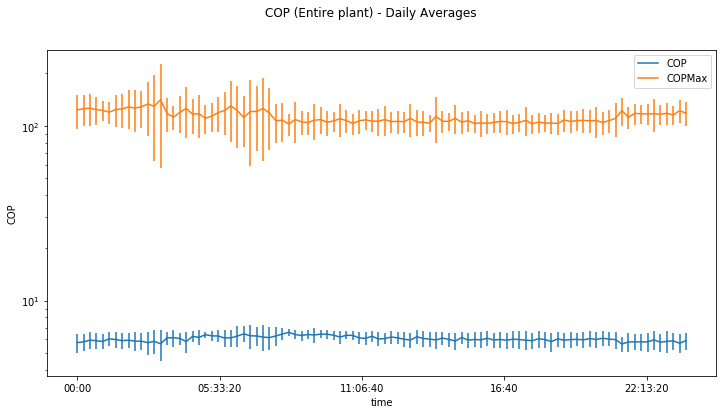

In [19]:
f = plt.figure(figsize=(12, 6))
f.suptitle('COP (Entire plant) - Daily Averages')

ax = means['COP'].plot(legend=True, logy=True, yerr=bytime['COP'].std())
ax = means['COPMax'].plot(legend=True, logy=True, yerr=bytime['COPMax'].std())
ax.set(ylabel='COP');

### Temperatures

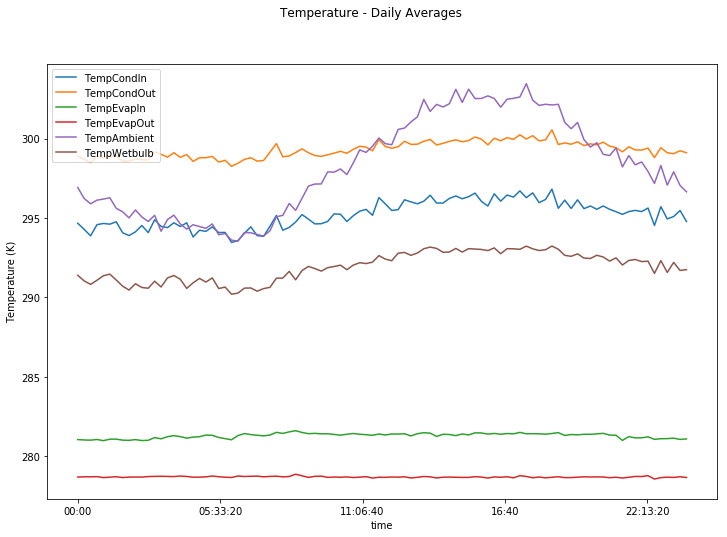

In [14]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Temperature - Daily Averages')

for col in TEMP_FIELDS:
    ax = means[col].plot(legend=True)
ax.set(ylabel='Temperature (K)');

### Power vs. Cooling

Input power vs. total cooling done by the evaporator.

(0, 1615448.6993634969)

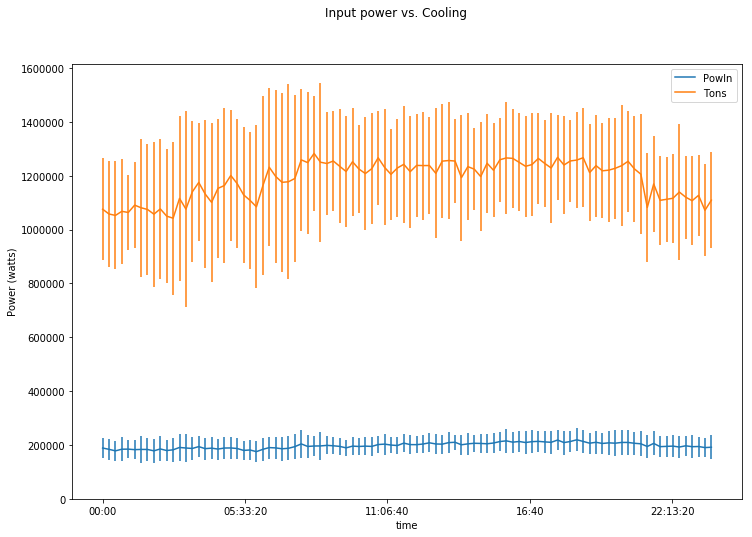

In [20]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Input power vs. Cooling')

ax = means['PowIn'].plot(legend=True, yerr=bytime['PowIn'].std())
ax = means['Tons'].plot(legend=True, yerr=bytime['Tons'].std())

ax.set(ylabel='Power (watts)')
ax.set_ylim(bottom=0)

### Condenser/cooling tower cycle power

(273.15, 304.11615917243273)

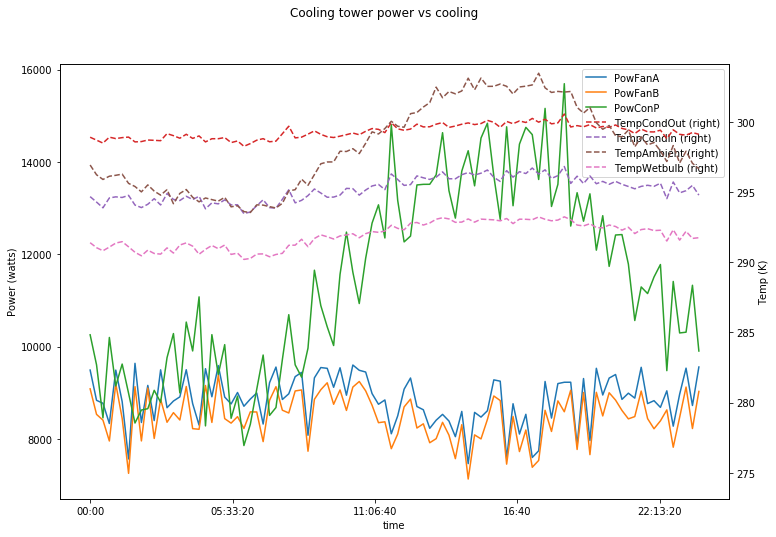

In [21]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Cooling tower power vs cooling')

ax = means['PowFanA'].plot(legend=True)
ax = means['PowFanB'].plot(legend=True)
ax = means['PowConP'].plot(legend=True)
ax.set(ylabel='Power (watts)')
ax = means['TempCondOut'].plot(legend=True, secondary_y=True, linestyle='--')
ax = means['TempCondIn'].plot(legend=True, secondary_y=True, linestyle='--')
ax = means['TempAmbient'].plot(legend=True, secondary_y=True, linestyle='--')
ax = means['TempWetbulb'].plot(legend=True, secondary_y=True, linestyle='--')
ax.set(ylabel='Temp (K)')
ax.set_ylim(bottom=273.15)  # starting at freezing

### Fan speed (%) vs fan power

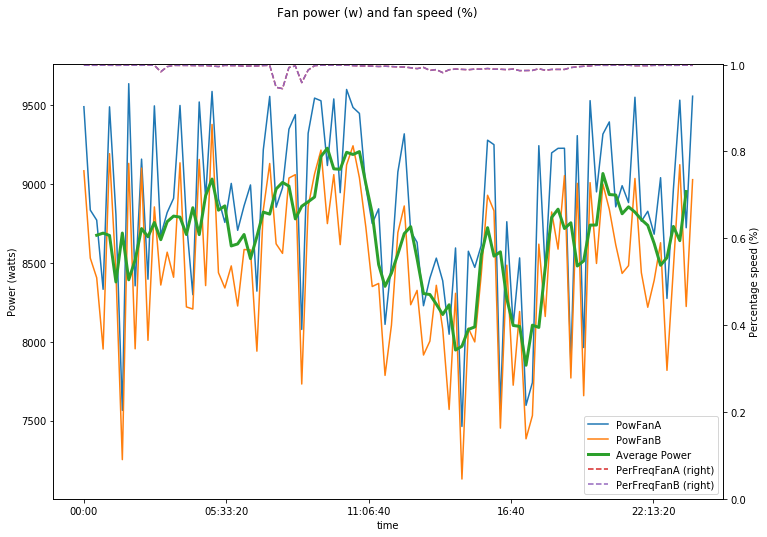

In [23]:
f = plt.figure(figsize=(12, 8))
f.suptitle('Fan power (w) and fan speed (%)')

ax = means['PowFanA'].plot(legend=True)
ax = means['PowFanB'].plot(legend=True)
ax = means.loc[:, ('PowFanA', 'PowFanB')].mean(axis=1)\
          .rolling(window=4, center=True).mean()\
          .plot(legend=True, label='Average Power', linewidth=3)
ax.set(ylabel='Power (watts)')
ax = means['PerFreqFanA'].plot(legend=True, secondary_y=True, linestyle='--')
ax = means['PerFreqFanB'].plot(legend=True, secondary_y=True, linestyle='--')
ax.set(ylabel='Percentage speed (%)')
ax.set_ylim(bottom=0);